In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from pathlib import Path
import cv2
import glob
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as process_mobileNetV3Large
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as process_efficientNetV2B0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

train_path = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/train'
test_path  = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/test'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

In [ ]:
#data awal setelah dipisah secara manual. Data yang lebih dari 1000, telah dipisah secara manual
print('Dataset Training UnderSampling Balanced')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


print('Dataset Testing UnderSampling Balanced')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

Dataset Training UnderSampling Balanced
303 	 bacterial_leaf_blight
303 	 bacterial_leaf_streak
303 	 bacterial_panicle_blight
303 	 blast
303 	 brown_spot
303 	 dead_heart
303 	 downy_mildew
303 	 hispa
303 	 normal
303 	 tungro
Dataset Testing UnderSampling Balanced
34 	 hispa
34 	 bacterial_panicle_blight
34 	 bacterial_leaf_blight
34 	 normal
34 	 downy_mildew
34 	 tungro
34 	 blast
34 	 bacterial_leaf_streak
34 	 brown_spot
34 	 dead_heart


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

Found 3030 files belonging to 10 classes.
Using 2727 files for training.
Found 3030 files belonging to 10 classes.
Using 303 files for validation.
Found 340 files belonging to 10 classes.


In [ ]:
#Ensemble Model Using Concatenation Method

model_MobileNetV3Large = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model_EfficientNetV2B0 = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

for layer in model_MobileNetV3Large.layers:
        layer.trainable = False


for layer in model_EfficientNetV2B0.layers:
        layer.trainable = False

models = [model_MobileNetV3Large, model_EfficientNetV2B0]
print(models)

24274472/24274472 [==============================] - 2s 0us/step
[<keras.engine.functional.Functional object at 0x7fb2a4149490>, <keras.engine.functional.Functional object at 0x7fb279a907f0>]


In [ ]:
inp = Input((224,224,3))

mobileNetV3Large_process = Lambda(process_mobileNetV3Large)(inp)
MobileNetV3Large = model_MobileNetV3Large(mobileNetV3Large_process)

efficientNetV2B0_process = Lambda(process_efficientNetV2B0)(inp)
EfficientNetV2B0 = model_EfficientNetV2B0(efficientNetV2B0_process)

x = Concatenate()([MobileNetV3Large, EfficientNetV2B0])
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(10, activation='softmax')(x) 

concatenation_ensemble_model = Model(inp, out)
concatenation_ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  

In [ ]:
#custom callback
class_names = train_ds.class_names
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = concatenation_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 199s 2s/step - loss: 1.7222 - accuracy: 0.6029 - val_loss: 0.7242 - val_accuracy: 0.8086
Epoch 2/10
86/86 [==============================] - 3s 33ms/step - loss: 0.1536 - accuracy: 0.9556 - val_loss: 0.6688 - val_accuracy: 0.8581
Epoch 3/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0449 - accuracy: 0.9886 - val_loss: 0.6743 - val_accuracy: 0.8581
Epoch 4/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0306 - accuracy: 0.9949 - val_loss: 0.6361 - val_accuracy: 0.8581
Epoch 5/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0158 - accuracy: 0.9971 - val_loss: 0.6500 - val_accuracy: 0.8713
Epoch 6/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0152 - accuracy: 0.9971 - val_loss: 0.6659 - val_accuracy: 0.8680
Epoch 7/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.6175 - val_accuracy: 0.8614
Epoch 8/10
86

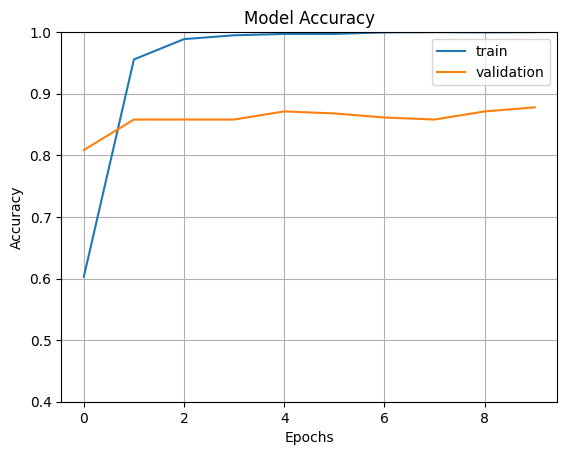

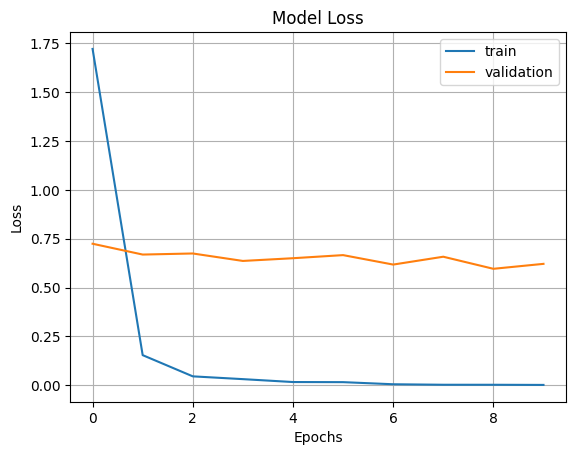

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = concatenation_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

340/340 [==============================] - 23s 56ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.86      0.91      0.89        34
   bacterial_leaf_streak       0.97      0.97      0.97        34
bacterial_panicle_blight       0.97      0.94      0.96        34
                   blast       0.73      0.79      0.76        34
              brown_spot       0.87      0.79      0.83        34
              dead_heart       0.97      0.94      0.96        34
            downy_mildew       0.83      0.74      0.78        34
                   hispa       0.79      0.68      0.73        34
                  normal       0.88      0.88      0.88        34
                  tungro       0.70      0.88      0.78        34

                accuracy                           0.85       340
               macro avg       0.86      0.85      0.85       340
            weighted avg       0.86      0.85      0.85       340



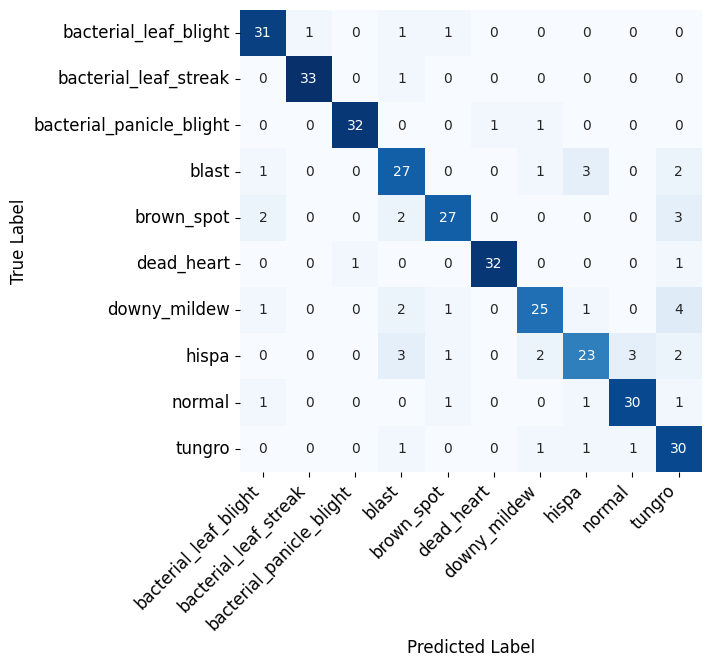

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="ConcatenationEnsemble-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
concatenation_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleConcatenation_UnderSampling_224.h5')

In [ ]:
#Ensemble Model using Average Method
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EfficientNetV2B0_UnderSampling_224.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='EfficientNetV2B0')
model_2 = load_model('/content/drive/MyDrive/PaddyDisease/PaddyDisease_MobileNetV3Large_UnderSampling_224.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='MobileNetV3Large')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
average_ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='EnsembleAverage')

In [ ]:
average_ensemble_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = average_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 18s 66ms/step - loss: 0.1060 - accuracy: 0.9835 - val_loss: 0.8851 - val_accuracy: 0.8020
Epoch 2/10
86/86 [==============================] - 3s 34ms/step - loss: 0.1110 - accuracy: 0.9765 - val_loss: 0.8631 - val_accuracy: 0.8284
Epoch 3/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0809 - accuracy: 0.9864 - val_loss: 0.8227 - val_accuracy: 0.8416
Epoch 4/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0765 - accuracy: 0.9886 - val_loss: 0.9905 - val_accuracy: 0.8449
Epoch 5/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0717 - accuracy: 0.9905 - val_loss: 0.8241 - val_accuracy: 0.8416
Epoch 6/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0400 - accuracy: 0.9960 - val_loss: 0.7998 - val_accuracy: 0.8416
Epoch 7/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0216 - accuracy: 0.9974 - val_loss: 0.8480 - val_accuracy: 0.8779
Epoch 8/10
8

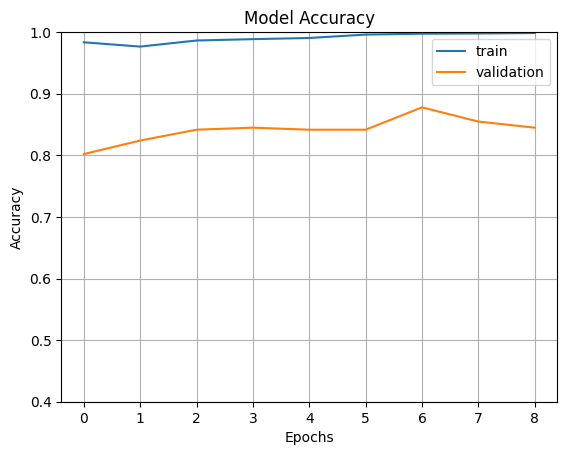

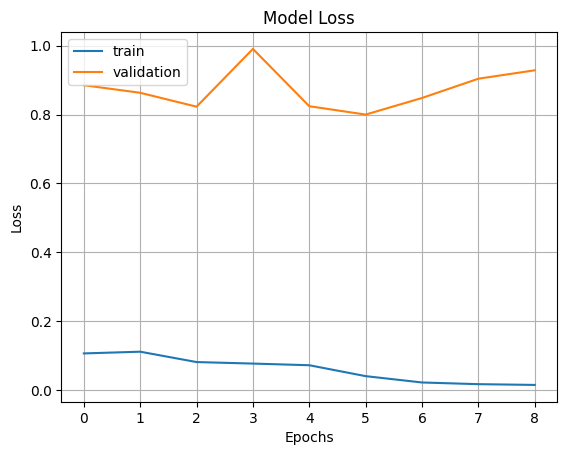

In [ ]:
import matplotlib.pyplot as plt

plt.plot([0.9835,0.9765,0.9864,0.9886,0.9905,0.9960,0.9974,0.9978,0.9985])
plt.plot([0.8020,0.824,0.8416,0.8449,0.8416,0.8416,0.8779,0.8548,0.8449])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot([0.1060,0.1110,0.0809,0.0765,0.0717,0.0400,0.0216,0.0167,0.0145])
plt.plot([0.8851,0.8631,0.8227,0.9905,0.8241,0.7998,0.8480,0.9040,0.9284])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = average_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

340/340 [==============================] - 7s 13ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.89      0.94      0.91        34
   bacterial_leaf_streak       0.97      0.94      0.96        34
bacterial_panicle_blight       0.94      0.94      0.94        34
                   blast       0.65      0.76      0.70        34
              brown_spot       0.82      0.82      0.82        34
              dead_heart       0.92      0.97      0.94        34
            downy_mildew       0.86      0.74      0.79        34
                   hispa       0.81      0.74      0.77        34
                  normal       0.93      0.82      0.87        34
                  tungro       0.78      0.85      0.82        34

                accuracy                           0.85       340
               macro avg       0.86      0.85      0.85       340
            weighted avg       0.86      0.85      0.85       340



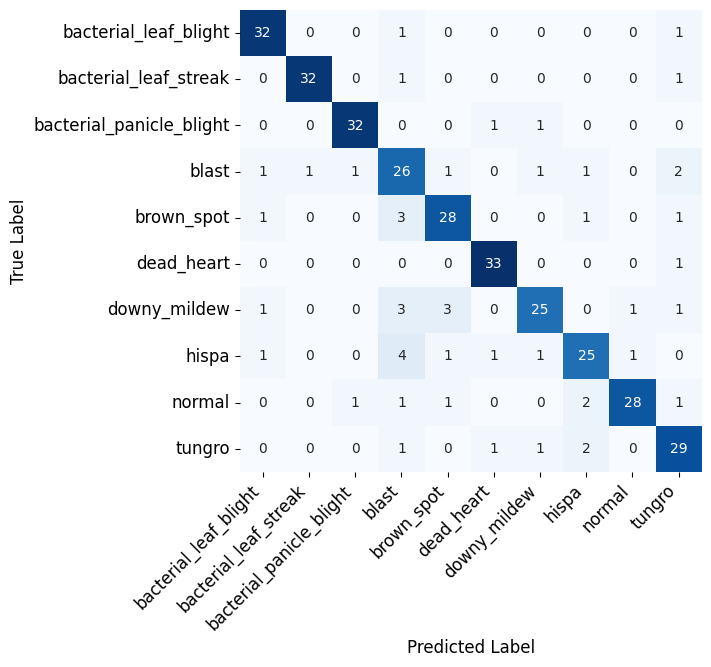

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="AverageEnsemble-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
average_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleAverage_UnderSampling_224.h5')

ValueError: ignored

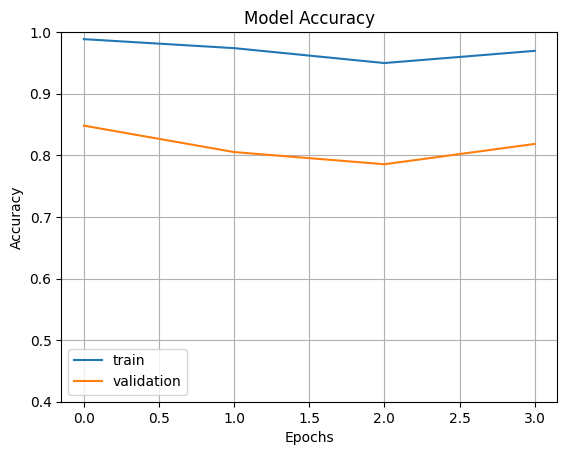

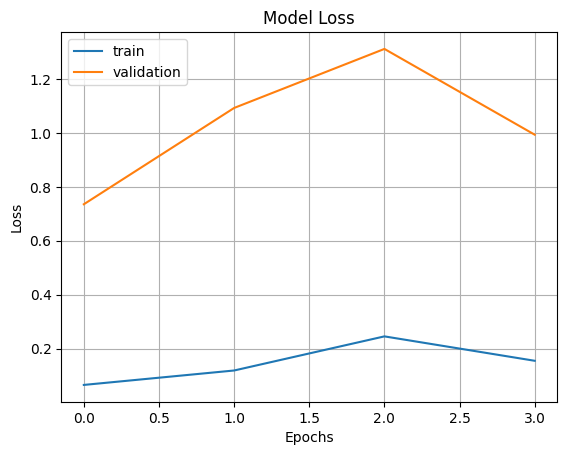

In [ ]:
#Average Training Graph - 256
import matplotlib.pyplot as plt

plt.plot([0.9886,0.9740,0.9498,0.9696])
plt.plot([0.8482,0.8053,0.7855,0.8185])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot([0.0655,0.1190,0.2455,0.1550])
plt.plot([0.7354,1.0925,1.3114,0.9933])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()